In [10]:
import requests
import defs
import pandas as pd
import datetime

Open a session so that requests don't have to re-connect each time

In [11]:
session = requests.Session()

Consider turning instrument(s) into a list...

In [12]:
ins_df = pd.read_csv("./Data/available_instruments.csv").drop(["Unnamed: 0"], axis=1)
ins_df.head()

,name,type,displayName,pipLocation,marginRate
0,NL25_EUR,CFD,Netherlands 25,-2,0.10
1,CHINAH_HKD,CFD,China H Shares,0,0.10
2,EUR_ZAR,CURRENCY,EUR/ZAR,-4,0.05
3,EUR_CHF,CURRENCY,EUR/CHF,-4,0.04
4,NAS100_USD,CFD,US Nas 100,0,0.05


In [13]:
our_curr = ["GBP", "USD", "EUR", "JPY", "CHF", "NZD", "CAD"]

In [14]:
def fetch_candles(pair_name, count, granularity):
    url = f"{defs.OANDA_URL}/instruments/{pair_name}/candles"
    params = dict(
        count = count,
        granularity = granularity,
        price="MBA"
    )
    response = session.get(url, params=params, headers=defs.SECURE_HEADER)
    return response.status_code, response.json()

In [15]:

status_code, res = fetch_candles("EUR_USD", 10, "H1")
print(status_code)

200


In [16]:
def get_candles_df(response):

    our_data =[]

    prices = ["bid", "mid", "ask"]
    ohlc = ["o", "h", "l", "c"]

    for candle in response["candles"]:
        if candle["complete"] == False:
            continue

        new_dict = {}
        new_dict["ticker"] = response["instrument"]
        new_dict["time"] = candle["time"]
        new_dict["volume"] = candle["volume"]
        
        for price in prices:
            for oh in ohlc:
                new_dict[f"{price}_{oh}"] = candle[price][oh]

        our_data.append(new_dict)
        
    return pd.DataFrame.from_dict(our_data)


In [17]:
df = get_candles_df(res)
df

,ticker,time,volume,bid_o,bid_h,bid_l,bid_c,mid_o,mid_h,mid_l,mid_c,ask_o,ask_h,ask_l,ask_c
0,EUR_USD,2023-07-07T00:00:00.000000000Z,2362,1.08886,1.08904,1.08816,1.08845,1.08894,1.08912,1.08824,1.08852,1.08902,1.08920,1.08831,1.08859
1,EUR_USD,2023-07-07T01:00:00.000000000Z,3068,1.08843,1.08906,1.08840,1.08863,1.08850,1.08914,1.08848,1.08870,1.08858,1.08923,1.08855,1.08878
2,EUR_USD,2023-07-07T02:00:00.000000000Z,2287,1.08864,1.08879,1.08827,1.08853,1.08871,1.08886,1.08835,1.08861,1.08878,1.08893,1.08843,1.08869
3,EUR_USD,2023-07-07T03:00:00.000000000Z,2026,1.08855,1.08909,1.08853,1.08870,1.08862,1.08916,1.08861,1.08878,1.08870,1.08925,1.08868,1.08887
4,EUR_USD,2023-07-07T04:00:00.000000000Z,1323,1.08871,1.08946,1.08848,1.08903,1.08879,1.08954,1.08856,1.08912,1.08887,1.08962,1.08865,1.08920
5,EUR_USD,2023-07-07T05:00:00.000000000Z,2348,1.08905,1.08956,1.08858,1.08866,1.08912,1.08963,1.08865,1.08874,1.08920,1.08970,1.08872,1.08882
6,EUR_USD,2023-07-07T06:00:00.000000000Z,3778,1.08870,1.08996,1.08805,1.08823,1.08877,1.09004,1.08812,1.08831,1.08884,1.09012,1.08820,1.08839
7,EUR_USD,2023-07-07T07:00:00.000000000Z,5880,1.08822,1.08902,1.08709,1.08755,1.08830,1.08910,1.08716,1.08762,1.08837,1.08917,1.08723,1.08770
8,EUR_USD,2023-07-07T08:00:00.000000000Z,4368,1.08753,1.08802,1.08662,1.08773,1.08761,1.08810,1.08670,1.08780,1.08769,1.08818,1.08678,1.08787


In [18]:
def save_file(candles_df, pair, granularity):
    candles_df.to_csv(f"./data/{pair}_{granularity} {datetime.datetime.now().strftime('%Y%m%d%H%M')}.csv")

In [19]:
save_file(df, "EUR_USD", "H1")

In [20]:
def create_data(pair, granularity):
    code, json_data = fetch_candles(pair, 4000, granularity)
    if code != 200:
        print(f"{pair} Error: {code}")
        return
    df = get_candles_df(json_data)
    print(f"{pair} loaded {df.shape[0]} candles from {df.time.min()} to {df.time.max()}")
    save_file(df, pair, granularity)

In [21]:
create_data("EUR_USD", "H1")

EUR_USD loaded 3999 candles from 2022-11-15T18:00:00.000000000Z to 2023-07-07T08:00:00.000000000Z


In [22]:
def our_pairs(our_curr):

    pairs=[]
    
    for i in range(len(our_curr)):
        if i== 0:
            j=1
        else:
            j=0

        while (j) < len(our_curr):
            if i != j:
                new_pair = f"{our_curr[i]}_{our_curr[j]}"
                if new_pair in ins_df.name.unique():
                    pairs.append(f"{our_curr[i]}_{our_curr[j]}")
            j = j + 1
    
    return pairs


In [23]:
pairs = our_pairs(our_curr)
print(len(pairs))

21


In [25]:
for pair in pairs:
    create_data(pair, "H1")

GBP_USD loaded 3999 candles from 2022-11-15T18:00:00.000000000Z to 2023-07-07T08:00:00.000000000Z
GBP_JPY loaded 3999 candles from 2022-11-15T18:00:00.000000000Z to 2023-07-07T08:00:00.000000000Z
GBP_CHF loaded 3999 candles from 2022-11-15T18:00:00.000000000Z to 2023-07-07T08:00:00.000000000Z
GBP_NZD loaded 3999 candles from 2022-11-15T18:00:00.000000000Z to 2023-07-07T08:00:00.000000000Z
GBP_CAD loaded 3999 candles from 2022-11-15T18:00:00.000000000Z to 2023-07-07T08:00:00.000000000Z
USD_JPY loaded 3999 candles from 2022-11-15T18:00:00.000000000Z to 2023-07-07T08:00:00.000000000Z
USD_CHF loaded 3999 candles from 2022-11-15T18:00:00.000000000Z to 2023-07-07T08:00:00.000000000Z
USD_CAD loaded 3999 candles from 2022-11-15T18:00:00.000000000Z to 2023-07-07T08:00:00.000000000Z
EUR_GBP loaded 3999 candles from 2022-11-15T18:00:00.000000000Z to 2023-07-07T08:00:00.000000000Z
EUR_USD loaded 3999 candles from 2022-11-15T18:00:00.000000000Z to 2023-07-07T08:00:00.000000000Z
EUR_JPY loaded 3999 

<AxesSubplot:>

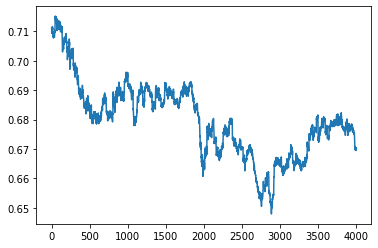

In [30]:
import matplotlib.pyplot as plt

testdf = pd.read_csv("./Data/CAD_CHF_H1 202307071009.csv")
testdf["bid_o"].plot()